In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity


In [25]:
path = r"C:\Users\bashi\Documents\Sadia\US documents\SUNY albany\Charalampos Chelmis\CARES homeless project\Results\Wayfinding_firstApproach\20210527_Final Analysis for ASONAM\Final Results\Github"

In [26]:
df = pd.read_csv(path+"\\ToyDataset.csv").drop(['Unnamed: 0'],axis=1)
df1 = pd.read_csv(path+"\\Data one hot encoded.csv").drop(['Unnamed: 0'],axis=1)
clientID = df.ClientID.unique()

In [27]:
# separating the living situation and the exit destination into categories
goal = [10,11]
closer = [3,19,20,21,22,23,25,26,28,31]
trans = [1,2,4,5,6,12,13,14,15,18,27,29]
no_progress = [7,16]
hard_to_judge = [8,9,17,24,30,99]

In [28]:
# preparing the data for target
T = pd.DataFrame()
t = ["ultimate goal","closer to exit","transitional phase","no progress or worse","hard to judge"]
for i in [goal,closer,trans,no_progress,hard_to_judge]:
    
    temp = df1.loc[df[df['Destination'].isin(i)].index] 
    temp = temp.drop(['EnrollmentID', 'ClientID', 'ProjectID', 'EntryDate', 
                'ProjectType', 'ExitID', 'ExitDate', 'HouseholdID'],axis = 1)
    if i == goal:
        y = pd.DataFrame(["ultimate goal"],index=['target'])
    elif i == closer:
        y = pd.DataFrame(["closer to exit"],index=['target'])
    elif i == trans:
        y = pd.DataFrame(["transitional phase"],index=['target'])
    elif i == no_progress:
        y = pd.DataFrame(["no progress or worse"],index=['target'])
    elif i == hard_to_judge:
        y = pd.DataFrame(["hard to judge"],index=['target'])
        
    x = pd.concat([y,temp.sum(axis=0)])
    T = T.append(x.T,ignore_index=True)
    
# preparing the data for project type
A = df1[["EnrollmentID","ClientID","ProjectType"]]
M = df1.drop(["ProjectType"],axis = 1)
p = np.sort(A['ProjectType'].unique())
P = len(p)
F = pd.DataFrame()
for i in range(P):
    S = A[A["ProjectType"]==p[i]]
    M_S = M[M['EnrollmentID'].isin(S['EnrollmentID'])].drop(['EnrollmentID', 'ClientID', 'ProjectID', 'EntryDate',
        'ExitID','ExitDate','HouseholdID'],axis = 1)
    y = pd.DataFrame([p[i]],index=['target'])
    M_S = pd.concat([y,M_S.sum(axis=0)])
    F = F.append(M_S.T,ignore_index=True)

F = F.append(T,ignore_index = True)
F = F.set_index('target')

In [29]:
# calculating tf_idf for project type
tf_idf = pd.DataFrame([],index = F.index, columns = F.columns)
for i in range(len(F.index)):
    for j in range(len(F.columns)):
        temp = F[F.columns[j]]
        tf = temp.loc[F.index[i]]
        n = len(temp[temp!=0])+1
        tf_idf.loc[F.index[i]][F.columns[j]] = tf * max(0,np.log(P/n))

tf_idf_norm = pd.DataFrame([],index = tf_idf.index, columns = tf_idf.columns)
total = list(p) + t  
for i in  total:
    if np.sqrt(np.square(tf_idf).sum(axis=1)).loc[i] == 0:
            tf_idf_norm.loc[i] = 0
    else:
        tf_idf_norm.loc[i] = tf_idf.loc[i]/np.sqrt(np.square(tf_idf).sum(axis=1)).loc[i]
    
tf_idf_norm.to_csv(path+"\\Normalized TF_IDF for project type and target.csv")

tf_idf_norm = pd.read_csv(path+"\\Normalized TF_IDF for project type and target.csv")
tf_idf_norm = tf_idf_norm.set_index("target",drop=True)

In [30]:
# separating out the clients that reached ultimate goal 
data,data1 = pd.DataFrame(),pd.DataFrame()
for i in range(len(clientID)):
    temp = df[df["ClientID"]==clientID[i]]
    if temp['Destination'].iloc[-1] in goal:
        temp1 = df1.loc[temp.index]
        data = data.append(temp,ignore_index=True)
        data1 = data1.append(temp1,ignore_index=True)


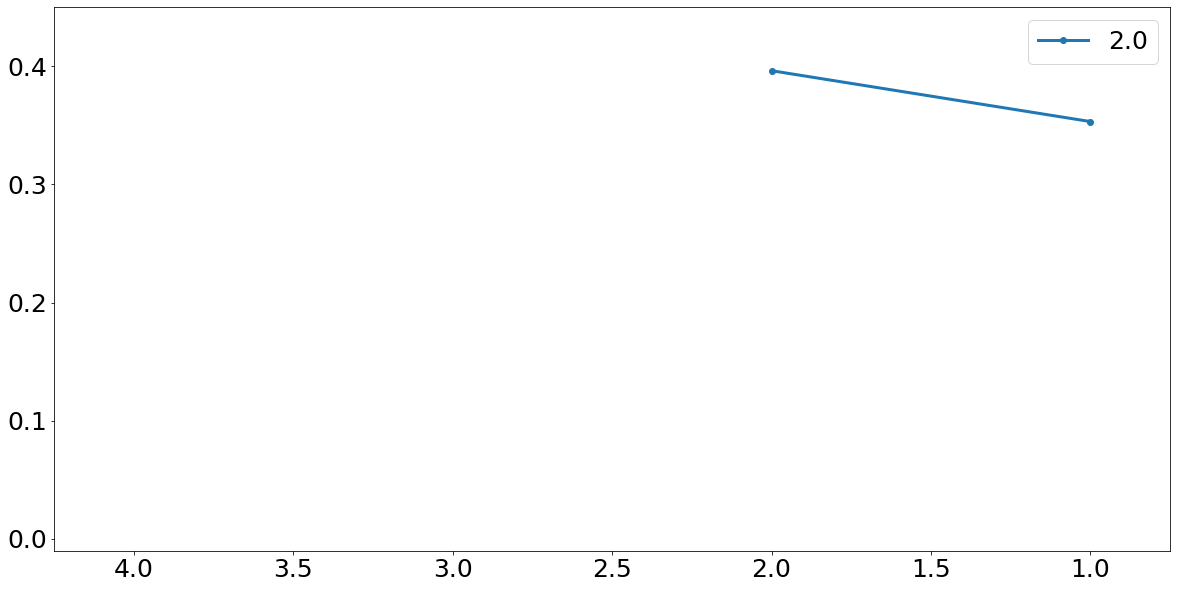

In [31]:
# recording effective pathway 
client = data1.ClientID.unique()
pathway = pd.DataFrame()
maxima = 0
for i in range(len(client)):
    temp1 = data1[data1['ClientID']==client[i]]
    temp = data[data['ClientID']==client[i]]
    pathway = pathway.append({"ClientID":client[i],"path":list(temp1['ProjectType'].unique())+['ultimate goal']},ignore_index=True)
    if len(temp['ProjectType'].unique())>maxima:
        maxima = len(temp1['ProjectType'].unique())

        
# finding the cosine similarity
n = maxima
cosine_avg = pd.DataFrame(columns = ['step']+[b for b in range(n)],index=range(n))
for k in range(2,n+1):
    cosine = pd.DataFrame(index = range(len(client)),columns=[a for a in range(k)])
    for i in range(len(client)):
        temp = pathway[pathway['ClientID']==client[i]]['path'].values[0]
        if len(temp)-1!= k:
            continue
        if len(temp)-1 == 1:
            continue
        for j in range(len(temp)-1):
            cos = pd.DataFrame(tf_idf_norm.loc[str(temp[j])])    
            x = pd.DataFrame(tf_idf_norm.loc[str(temp[j+1])])
            cos = cos.T.append(x.T,ignore_index=True)
            cosine[k-j-1].iloc[i] = cosine_similarity(cos)[0][1]
    cosine = cosine.dropna(how="all")
    cosine_avg["step"].loc[k-1] = k
    for z in range(k):
        cosine_avg[z].iloc[k-1] = cosine.mean()[z]   
cosine_avg = cosine_avg.set_index('step')
cosine_avg.columns = [k for k in range(1,n+1)]
cosine_avg = cosine_avg.dropna(how='all')

# plotting the similarity
plt.figure(figsize=(20,10))
for i in cosine_avg.index:
    plt.plot(cosine_avg.loc[i],'o-',linewidth = 3,label=i)
    plt.axis([4.25,0.75,-0.01,0.45])
    plt.legend(fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
plt.savefig(path+"\TF-IDF similarity to the next plot.png")

